In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_depth_annotated.zip

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_depth_velodyne.zip

In [ ]:
!mkdir data_depth_annotated data_depth_velodyne

In [ ]:
!unzip data_depth_annotated.zip -d data_depth_annotated
!unzip data_depth_velodyne.zip -d data_depth_velodyne

In [ ]:
!rm data_depth_annotated.zip data_depth_velodyne.zip

In [ ]:
import os

In [ ]:
path = "train"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()

print(filelist[:19])

data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}

print(len(data["image"]))
print(len(data["depth"]))
print(len(data["mask"]))



# Depth vs Disparity
+ https://docs.opencv.org/3.4/dd/d53/tutorial_py_depthmap.html
+ https://sourishghosh.com/2016/dense-disparity-maps-orb-descriptors/
+ https://vision.middlebury.edu/stereo/data/scenes2021/
+ https://aikiddie.wordpress.com/2017/05/24/depth-sensing-stereo-image/
+ https://paperswithcode.com/datasets?task=depth-estimation

In [ ]:
!wget https://raw.githubusercontent.com/andijakl/python-depthmaps/main/left_img.png
!wget https://raw.githubusercontent.com/andijakl/python-depthmaps/main/right_img.png

In [ ]:
!rm -r *

In [ ]:
!wget https://aikiddie.files.wordpress.com/2017/05/right.png
!wget https://aikiddie.files.wordpress.com/2017/05/left.png
!wget https://aikiddie.files.wordpress.com/2017/05/disparity_map1.png

+ cam0=[1758.23 0 872.36; 0 1758.23 552.32; 0 0 1]
+ cam1=[1758.23 0 872.36; 0 1758.23 552.32; 0 0 1]
+ doffs=0
+ baseline=124.86
+ width=1920
+ height=1080
+ ndisp=310
+ vmin=90
+ vmax=280

In [ ]:
!pip install kornia

     |████████████████████████████████| 474 kB 5.0 MB/s 


In [ ]:
!wget https://vision.middlebury.edu/stereo/data/scenes2021/data/chess2/im1.png # right
!wget https://vision.middlebury.edu/stereo/data/scenes2021/data/chess2/im0.png # left
!wget https://vision.middlebury.edu/stereo/data/scenes2021/data/chess2/disp0.pfm # left
!wget https://vision.middlebury.edu/stereo/data/scenes2021/data/chess2/disp1.pfm # right

In [ ]:
import numpy as np
import cv2
import os
import sys
import torch
import torchvision
import kornia
import kornia as K
import tensorflow as tf
from tensorflow.keras import layers
from torchvision import transforms

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)

In [ ]:
focal = 1758.23
baseline = 124.86

In [ ]:
right_depth: np.array = cv2.imread('/content/disp1.pfm', cv2.IMREAD_UNCHANGED)
left_depth: np.array = cv2.imread('/content/disp0.pfm', cv2.IMREAD_UNCHANGED)

right_depth[right_depth==np.inf] = 0
right_depth: np.array = cv2.normalize(right_depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

left_depth[left_depth==np.inf] = 0
left_depth: np.array = cv2.normalize(left_depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

right: np.array = cv2.imread('/content/im1.png')
left: np.array = cv2.imread('/content/im0.png')

right: np.array = cv2.normalize(right, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
left: np.array = cv2.normalize(left, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

In [ ]:
right_camera_matrix = np.array([
    [1758.23, 0, 872.36],
    [0, 1758.23, 552.32],
    [0, 0, 1]
])

left_camera_matrix = np.array([
    [1758.23, 0, 872.36],
    [0, 1758.23, 552.32],
    [0, 0, 1]
])

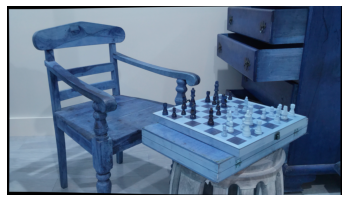

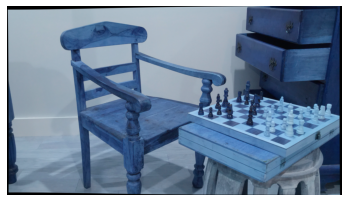

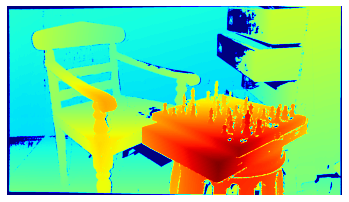

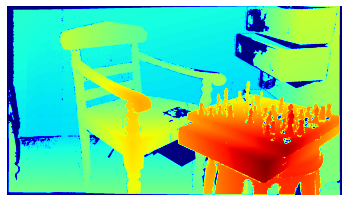

In [ ]:
cmap = plt.cm.jet
cmap.set_bad(color="black")
plt.imshow(right); plt.axis('off'); plt.show()
plt.imshow(left); plt.axis('off'); plt.show()
plt.imshow(right_depth, cmap=cmap); plt.axis('off'); plt.show()
plt.imshow(left_depth, cmap=cmap); plt.axis('off'); plt.show()

In [ ]:
left: torch.tensor = K.image_to_tensor(left)  # CxHxW / torch.uint8
right: torch.tensor = K.image_to_tensor(right)  # CxHxW / torch.uint8
left_depth: torch.tensor = K.image_to_tensor(left_depth)  # CxHxW / torch.uint8
right_depth: torch.tensor = K.image_to_tensor(right_depth)  # CxHxW / torch.uint8

In [ ]:
transform = torchvision.transforms.ToTensor()

In [ ]:
left_camera_matrix: torch.tensor = transform(left_camera_matrix)
right_camera_matrix: torch.tensor = transform(right_camera_matrix)

In [ ]:
device = "cpu"

In [ ]:
left = left.to(device)
right = right.to(device)
left_depth = left_depth.to(device)
right_depth = right_depth.to(device)

In [ ]:
left_camera_matrix = left_camera_matrix.to(device)
right_camera_matrix = right_camera_matrix.to(device)

In [ ]:
# Camera transformation matrix between 
src_trans_dst = torch.tensor(
    (
        (1, 0, 0, 0),
        (0, 1, 0, 0),
        (0, 0, 1, 0),
        (0, 0, 0, 1),
    )
)[None].to(device)
src_trans_dst = src_trans_dst.float()

In [ ]:
left = left.float()
right = right.float()
left_depth = left_depth.float()
right_depth = right_depth.float()
left_camera_matrix = left_camera_matrix.float()
right_camera_matrix = right_camera_matrix.float()

In [ ]:
camera_baseline = 124.86
focal_length = left_camera_matrix[0, 0, 0]
transform_from_left_to_right = src_trans_dst
lambda_position, lambda_angle, lambda_s = 1e-3, 1e-3, 1e-2

In [ ]:
left = left.expand(1, -1, -1, -1)
right = right.expand(1, -1, -1, -1)
left_depth = left_depth.expand(1, -1, -1, -1)
right_depth = right_depth.expand(1, -1, -1, -1)

## Spatial Image Losses

### Photometric Consistency Loss


https://stackoverflow.com/questions/54408420/constructing-right-view-image-from-left-view-image-and-disparity-map
https://www.coursera.org/lecture/visual-perception-self-driving-cars/lesson-3-part-2-visual-depth-perception-computing-the-disparity-Q00hg
https://github.com/kornia/kornia
https://giters.com/kornia/kornia-examples/issues/16

In [ ]:
generated_right_img = kornia.geometry.warp_frame_depth(
    image_src=left,
    depth_dst=right_depth,
    src_trans_dst=torch.inverse(transform_from_left_to_right),
    camera_matrix=left_camera_matrix,
    normalize_points=True
)

generated_left_img = kornia.geometry.warp_frame_depth(
    image_src=right,
    depth_dst=left_depth,
    src_trans_dst=transform_from_left_to_right,
    camera_matrix=right_camera_matrix,
    normalize_points=True
)

In [ ]:
generated_right_img_output = kornia.tensor_to_image(generated_right_img) / 255.
generated_left_img_output = kornia.tensor_to_image(generated_left_img) / 255.

In [ ]:
original_right_img_output = kornia.tensor_to_image(right) / 255.
original_left_img_output = kornia.tensor_to_image(left) / 255.

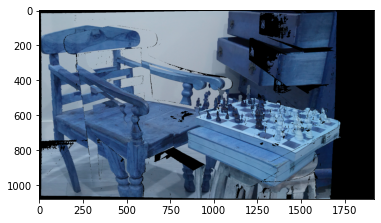

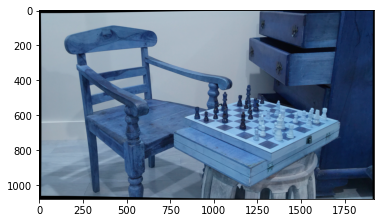

In [ ]:
plt.imshow(generated_right_img_output)
plt.show()
plt.imshow(original_right_img_output)
plt.show()

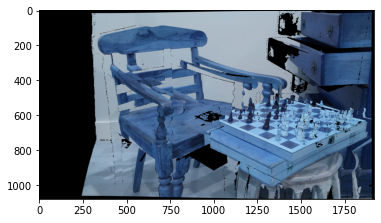

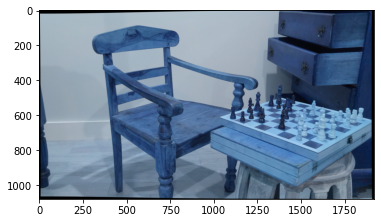

In [ ]:
plt.imshow(generated_left_img_output)
plt.show()
plt.imshow(original_left_img_output)
plt.show()

In [ ]:
def photometric_consistency_loss(y_true, y_pred):
    original_left_image = y_true[0]
    original_right_image = y_true[1]

    predicted_left_depth = y_pred[0]
    predicted_right_depth = y_pred[1]

    D_p_left = (baseline * focal_length) / predicted_left_depth
    D_p_right = (baseline * focal_length) / predicted_right_depth

    synthesized_left_image = original_right_image
    synthesized_right_image = 0

    lambda_s = 0.9
    
    # Structural similarity (SSIM) index
    left_ssim_loss = lambda_s * tf.reduce_mean(1 - tf.image.ssim(
            original_left_image, 
            synthesized_left_image,
            max_val=1241, 
            filter_size=7, 
            k1=0.01 ** 2, 
            k2=0.03 ** 2
        )
    )
    left_norm_1_loss = tf.reduce_mean(tf.abs(original_left_image - synthesized_left_image))
    
    right_ssim_loss = lambda_s *  tf.reduce_mean(1 - tf.image.ssim(
            original_right_image, 
            synthesized_right_image,
            max_val=1241, 
            filter_size=7, 
            k1=0.01 ** 2, 
            k2=0.03 ** 2
        )
    )
    right_norm_1_loss = tf.reduce_mean(tf.abs(original_right_image - synthesized_right_image))

    left_photometric_loss = lambda_s * left_ssim_loss + (1 - lambda_s) * left_norm_1_loss
    right_photometric_loss = lambda_s * right_ssim_loss + (1 - lambda_s) * right_norm_1_loss

    return tf.reduce_mean([left_photometric_loss, right_photometric_loss])
    

### Disparity Consistency Loss



In [ ]:
left_disparity = (baseline * focal) / left_depth
right_disparity = (baseline * focal) / right_depth

In [ ]:
print(left_disparity.shape)
print(right_disparity.shape)

torch.Size([1, 1, 1080, 1920])
torch.Size([1, 1, 1080, 1920])


In [ ]:
predicted_left_disparity = kornia.tensor_to_image(left_disparity) / 255.
predicted_right_disparity = kornia.tensor_to_image(right_disparity) / 255.

In [ ]:
generated_left_disparity  = kornia.geometry.warp_frame_depth(
    image_src=left_disparity,
    depth_dst=right_depth,
    src_trans_dst=transform_from_left_to_right,
    camera_matrix=left_camera_matrix,
)

generated_right_disparity = kornia.geometry.warp_frame_depth(
    image_src=right_disparity,
    depth_dst=left_depth,
    src_trans_dst=torch.inverse(transform_from_left_to_right),
    camera_matrix=right_camera_matrix,
)

In [ ]:
generated_left_disparity_img = kornia.tensor_to_image(generated_left_disparity) / 255.
generated_right_disparity_img = kornia.tensor_to_image(generated_right_disparity) / 255.

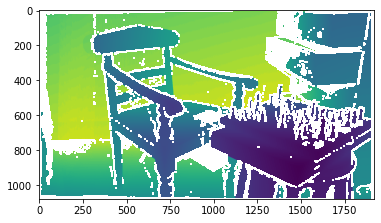

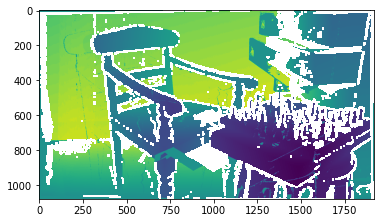

In [ ]:
plt.imshow(predicted_left_disparity)
plt.show()
plt.imshow(generated_left_disparity_img)
plt.show()

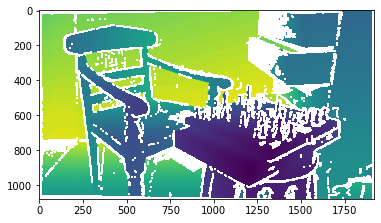

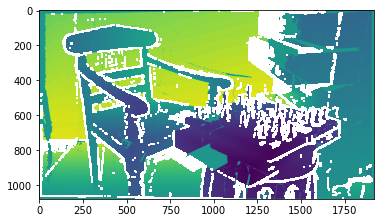

In [ ]:
plt.imshow(predicted_right_disparity)
plt.show()
plt.imshow(generated_right_disparity_img)
plt.show()

### Pose Consistency loss

In [ ]:
left_rotation = torch.tensor(
    (
        (1, 0, 0),

    )
)[None].to(device)
left_rotation = left_rotation.float()

left_translation = torch.tensor(
    (
        (1, 0, 0),
    )
)[None].to(device)
left_translation = left_translation.float()

In [ ]:
right_rotation = torch.tensor(
    (
        (0, 0, 1),
    )
)[None].to(device)
right_rotation = right_rotation.float()

right_translation = torch.tensor(
    (
        (0, 0, 1),
    )
)[None].to(device)
right_translation = right_translation.float()

In [ ]:
loss = torch.nn.L1Loss()(left_translation, right_translation) + torch.nn.L1Loss()(left_rotation, right_rotation)
print(loss)

tensor(1.3333)


## Temporal Image Losses

### Photometric Consistency loss

![](https://answers.opencv.org/upfiles/14659846287703544.png)



$P_{src}^{\{dst\}} = K_{dst} * T_{src}^{\{dst\}}$

$I_{src} = \\omega(I_{dst}, P_{src}^{\{dst\}}, D_{src})$

In [ ]:
left_euler = torch.tensor(((1, 0, 0)))[None].to(device)
left_euler = left_euler.float()

left_translation = torch.tensor(((1, 0, 0)))[None].to(device)
left_translation = left_translation.float()

In [ ]:
right_euler = torch.tensor(((0, 0, 1)))[None].to(device)
right_euler = right_euler.float()

right_translation = torch.tensor(((0, 0, 1)))[None].to(device)
right_translation = right_translation.float()

In [ ]:
def euler_to_rotation(angle: torch.tensor):
    batch_size = angle.shape[0]
    
    zeros = torch.zeros(batch_size, 1)
    ones = torch.ones(batch_size, 1)    

    x, y, z = angle[:, 0], angle[:, 1], angle[:, 2]

    x_cos = torch.cos(x)
    x_sin = torch.sin(x)

    x = torch.tensor([
        [
          x_cos, x_sin, zeros,
         -x_sin, x_cos, zeros,
          zeros, zeros, ones
        ]
    ]).reshape(batch_size, 3, 3)

    y_cos = torch.cos(y)
    y_sin = torch.sin(y)

    y = torch.tensor([
        [ 
            y_cos, zeros, -y_sin,
            zeros, ones , zeros,
            y_sin, zeros,  y_cos
        ]
    ]).reshape(batch_size, 3, 3)
    
    z_cos = torch.cos(z)
    z_sin = torch.sin(z)

    z = torch.tensor([
        [
            z_cos, z_sin, zeros,
           -z_sin, z_cos, zeros,
            zeros, zeros, ones
        ],
    ]).reshape(batch_size, 3, 3)
    
    return torch.bmm(torch.bmm(x, y), z)

In [ ]:
def construct_transformation_matrix(angle, translation_matrix):
    """
        Construct transformation matrix given angle matrix(B, 3) and translation matrix(B, 3)
        angle: Bx3
        translation_matrix: Bx3
        transformation matrix : Bx4x4
    """
    batch_size = angle.shape[0]
    assert angle.shape[0] == translation_matrix.shape[0]
    rotation_matrix = euler_to_rotation(angle) # Bx3x3

    assert rotation_matrix.shape[0] == translation_matrix.shape[0]
    
    translation_matrix = translation_matrix.unsqueeze(dim=2) # Bx3x1
    transformation_matrix = torch.cat((rotation_matrix, translation_matrix), dim=2) # Bx3x4

    identity = torch.tensor([0, 0, 0, 1]).to(translation_matrix.device) # 4
    identity = identity.repeat(batch_size, 1, 1) # Bx1x4

    transformation_matrix = torch.cat((transformation_matrix, identity), dim=1) # Bx4x4

    return transformation_matrix

In [ ]:
def construct_relative_transformation(rotation, translation, next_rotation, next_translation):
    """
        Construct T_k_k+1 given rotation and translation of I_k frame and 
        rotation and translation of I_k+1
    """
    I_k1_transformation = construct_transformation_matrix(rotation, translation)
    I_k2_transformation = construct_transformation_matrix(next_rotation, next_translation)

    return kornia.geometry.relative_transformation(I_k1_transformation, I_k2_transformation)

In [ ]:
current_to_next_transformation = construct_transformation_matrix(left_euler, left_translation)
next_to_current_transformation = construct_transformation_matrix(left_euler, left_translation)

In [ ]:
generated_current_image = kornia.warp_frame_depth(
    next_image,
    current_depth,
    next_to_current_transformation,
    left_camera_matrix
)

In [ ]:
generated_next_image = kornia.warp_frame_depth(
    current_image,
    next_depth,
    current_to_next_transformation,
    left_camera_matrix
)

### 3D Geometric Registration Loss